# Кластеризация
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][HW02] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [152]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
from typing import NoReturn, List
from collections import defaultdict
import collections

from enum import Enum

In [153]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

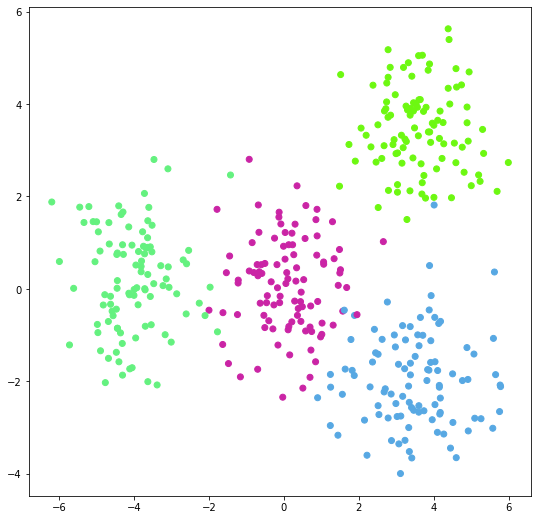

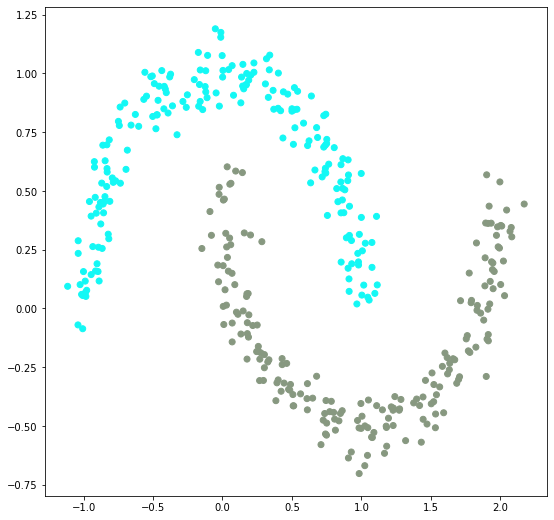

In [154]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)

X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)



### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудте реинициализировать пустые кластеры!__

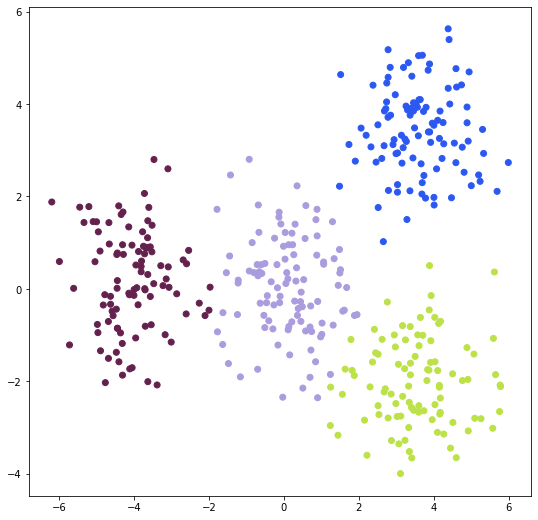

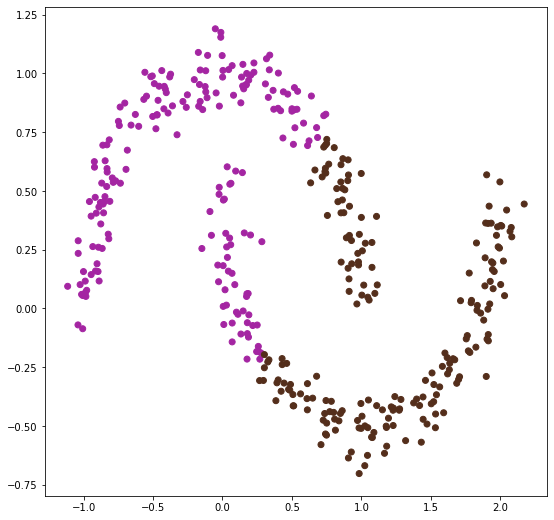

In [155]:
class KMeans:

    class InitClustVal(Enum):
        RAND = 0
        SAMPLE = 1
        KMEANS_PLUS = 2

    def __init__(self, n_clusters: int, init: str = "random", 
                 max_iter: int = 300):
        """
        
        Parameters
        ----------
        n_clusters : int
            Число итоговых кластеров при кластеризации.
        init : str
            Способ инициализации кластеров. Один из трех вариантов:
            1. random --- центроиды кластеров являются случайными точками,
            2. sample --- центроиды кластеров выбираются случайно из  X,
            3. k-means++ --- центроиды кластеров инициализируются 
                при помощи метода K-means++.
        max_iter : int
            Максимальное число итераций для kmeans.
        
        """
        self.n_clusters = n_clusters

        if init == "random":
            self.init = KMeans.InitClustVal.RAND
        elif init == "sample":
            self.init = KMeans.InitClustVal.SAMPLE
        elif init == "k-means++":
            self.init = KMeans.InitClustVal.KMEANS_PLUS
        else:
            raise ValueError("init ValueError:\n" +
                             "  1. random --- центроиды кластеров являются случайными точками,\n" +
                             "  2. sample --- центроиды кластеров выбираются случайно из  X, \n" +
                             "  3. k-means++ --- центроиды кластеров инициализируются \n")

        self.max_iter = max_iter

    def fit(self, X: np.array, y = None) -> NoReturn:
        """
        Ищет и запоминает в self.centroids центроиды кластеров для X.
        
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit обязаны принимать 
            параметры X и y, даже если y не используется).
        
        """
        centers = List[List]
        self.X = X

        if self.init == KMeans.InitClustVal.RAND:
            centers = self.__gen_rand_centers__(X, self.n_clusters)
        elif self.init == KMeans.InitClustVal.SAMPLE:
            centers = random.sample(list(X), self.n_clusters)
        else:
            pass

        self.tree = KDTree(centers, 30, metric="euclidean")
        for _ in range(self.max_iter):
            map_center_points = defaultdict(list)
            local_centers = self.tree.query(X, 1, return_distance=False) # [[ind]] ближайший ind центра к i точки
            for x, list_ind in zip(X, local_centers):
                ind = list_ind[0]
                map_center_points[ind].append(x)

            ind_empty, new_points = self.__fill_empty_clasters__(map_center_points, centers)
            if len(ind_empty) != 0:
                for ind, point in zip(ind_empty, new_points):
                    centers[ind] = point
                continue

            new_centers = []

            for i, center in enumerate(centers):
                cur_list_points = map_center_points[i]
                nw_center = sum(cur_list_points) / len(cur_list_points)
                new_centers.append(nw_center)

            centers = new_centers
            self.tree = KDTree(centers, 2, metric="euclidean")


        self.centers = centers

    def __fill_empty_clasters__(self, map_center_points: defaultdict(list), centers: List[List]):
        has_empty = False
        ind_empty = []

        for i, center in enumerate(centers):
            if len(map_center_points[i]) == 0:
                has_empty = True
                ind_empty.append(i)

        if not has_empty:
            return ([], [])

        new_points = []
        if self.init == KMeans.InitClustVal.RAND:
            new_points = self.__gen_rand_centers__(self.X, len(ind_empty))
        elif self.init == KMeans.InitClustVal.SAMPLE:
            new_points = np.random.choice(self.X, size=len(ind_empty), replace=False)
        else:
            raise NotImplementedError()
        return ind_empty, new_points


    def __calc_distances__(self, X: np.array, y: np.array) -> np.array:
        return np.array([np.sum((X - v) ** 2, axis=1) ** 0.5 for v in y])

    def __borderline_of_coordinates__(self, X: np.array) -> (np.array, np.array):
        mins = []
        maxs = []
        for vector_coordinate in X.T:
            mins.append(np.amin(vector_coordinate))
            maxs.append(np.amax(vector_coordinate))
        return np.array(mins), np.array(maxs)


    def __gen_rand_centers__(self, X: np.array, n: int) -> List[np.array]:
        result_centers = []
        for _ in range(n):
            mins, maxs = self.__borderline_of_coordinates__(X)
            center = []
            for min_, max_ in zip(mins, maxs):
                center.append(np.random.uniform(min_, max_))
            result_centers.append(center)
        return result_centers


    def predict(self, X: np.array) -> np.array:
        """
        Для каждого элемента из X возвращает номер кластера, 
        к которому относится данный элемент.
        
        Parameters
        ----------
        X : np.array
            Набор данных, для элементов которого находятся ближайшие кластера.
        
        Return
        ------
        labels : np.array
            Вектор индексов ближайших кластеров 
            (по одному индексу для каждого элемента из X).
        
        """
        res = []
        centers = self.tree.query(X, 1, return_distance=False)
        for list_center in centers:
            res.append(list_center[0])

        return np.array(res)

kmeans = KMeans(n_clusters=4, init='sample')
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2, init='sample')
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)


Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

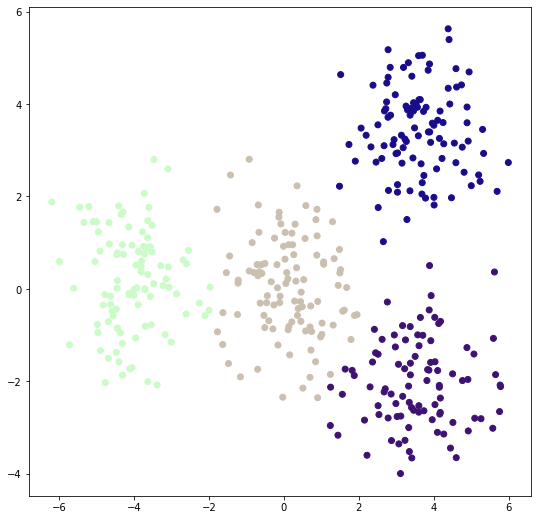

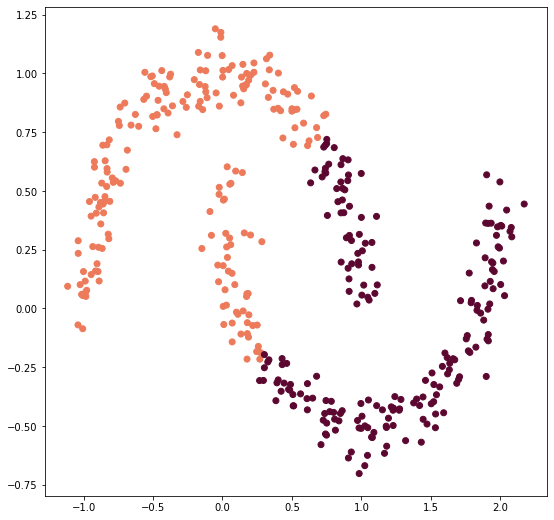

In [156]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [157]:
class DBScan:
    def __init__(self, eps: float = 0.5, min_samples: int = 5, 
                 leaf_size: int = 40, metric: str = "euclidean"):
        """
        
        Parameters
        ----------
        eps : float, min_samples : int
            Параметры для определения core samples.
            Core samples --- элементы, у которых в eps-окрестности есть 
            хотя бы min_samples других точек.
        metric : str
            Метрика, используемая для вычисления расстояния между двумя точками.
            Один из трех вариантов:
            1. euclidean 
            2. manhattan
            3. chebyshev
        leaf_size : int
            Минимальный размер листа для KDTree.

        """
        self.eps = eps
        self.min_sampes = min_samples
        self.leaf_size = leaf_size
        if metric not in ("euclidean", "manhattan", "chebyshev"):
            raise ValueError("metric ValueError:\n" +
                             "  1. euclidean\n" +
                             "  2. manhattan\n" +
                             "  3. chebyshev\n")
        self.metric = metric
        
    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        self.tree = KDTree(X, self.leaf_size, metric=self.metric)
        self.colour = 0
        self.X = X
        self.result = [0 for i in range(len(X))]

        for ind in range(len(X)):
            self.__dfs__(ind, 0)
        return np.array(self.result)

    def __dfs__(self, curr_i: int, colour: int):
        if self.result[curr_i] == 0:
            indexs = self.tree.query_radius([self.X[curr_i]], self.eps)

            if len(indexs[0]) < self.min_sampes:
                return
            if colour == 0:
                self.colour += 1
                colour = self.colour
            self.result[curr_i] = colour
            for ind in indexs[0]:
                self.__dfs__(ind, colour)

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

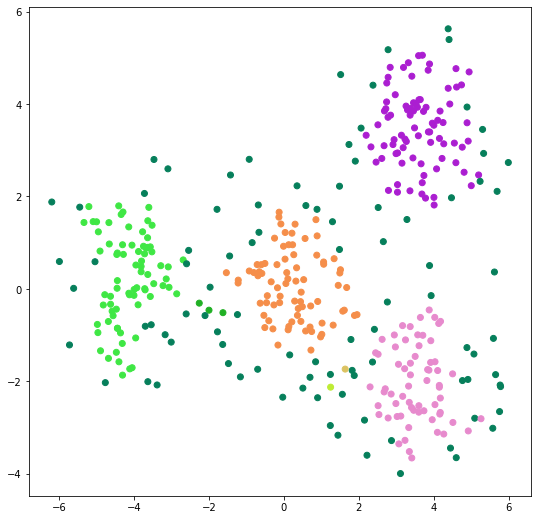

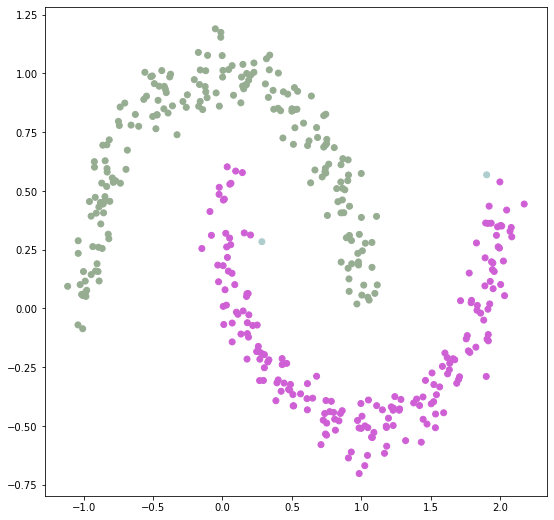

In [158]:
dbscan = DBScan(0.47, 4)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(0.2)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [159]:
class AgglomertiveClustering:
    def __init__(self, n_clusters: int = 16, linkage: str = "average"):
        """
        
        Parameters
        ----------
        n_clusters : int
            Количество кластеров, которые необходимо найти (то есть, кластеры 
            итеративно объединяются, пока их не станет n_clusters)
        linkage : str
            Способ для расчета расстояния между кластерами. Один из 3 вариантов:
            1. average --- среднее расстояние между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            2. single --- минимальное из расстояний между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            3. complete --- максимальное из расстояний между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
        """
        raise NotImplementedError()
    
    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        raise NotImplementedError()


Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

In [160]:
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2)
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

NotImplementedError: 

### Задание 4 (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки OpenCV. 

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [161]:
def read_image(path: str) -> np.asarray:
    """
    Читает изображение.

    Parameters
    ----------
    path : str
        Путь к изображению.
    
    Return
    ------
    image : np.array
        Трехмерный массив размера (N, M, C), 
        где N и M - размеры изображения, 
        а C - количество цветов (3 для обычного изображения).
    """
    m = cv2.imread(path)
    return np.asarray(cv2.cvtColor(m, cv2.COLOR_BGR2RGB)[:, :])

def show_image(image: np.array) -> NoReturn:
    """
    Выводит изображение

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    """
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image: np.array, path: str) -> NoReturn:
    """
    Сохраняет изображение.

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    path : str
        Путь для сохранения.
    """
    cv2.imwrite(path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

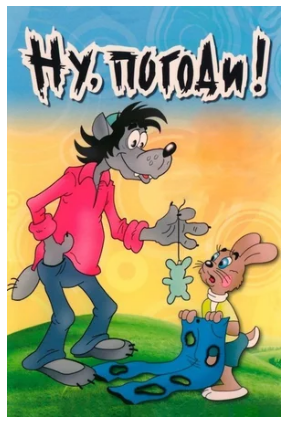

In [162]:
show_image(read_image("./image.png"))

### Задание 5 (1 балл)
Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [170]:
def clusterize_image(image, n_clusters=3):
    vector = image.reshape(-1, image.shape[-1])

    k_means = KMeans(n_clusters=n_clusters)
    k_means.fit(vector)
    clusters = k_means.predict(vector)

    result = vector
    colours = [np.mean(vector[clusters == cl], axis=0) for cl in range(n_clusters)]

    for cl in range(n_clusters):
        result[clusters == cl] = colours[cl]

    RBG_SIZE = 255
    result = result.reshape(image.shape)
    clusters_statistics(image.reshape(-1, 3) / RBG_SIZE, np.array(colours) / RBG_SIZE, clusters)  # Very slow (:
    return result

/Users/thebest/Documents/HSE/semester_5/ЧМ/hw2/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thebest/Documents/HSE/semester_5/ЧМ/hw2/venv/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


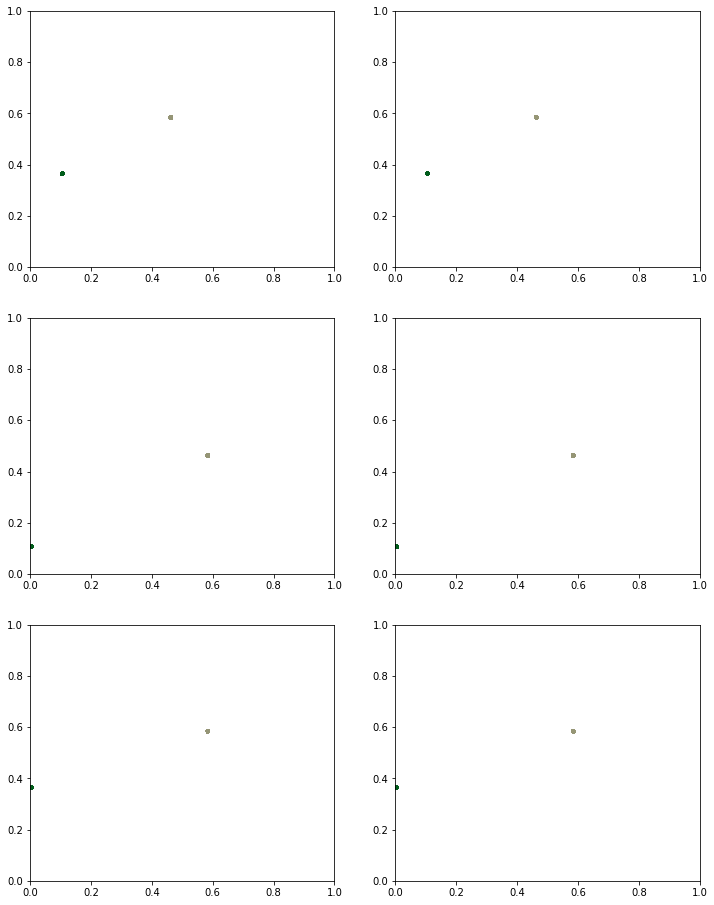

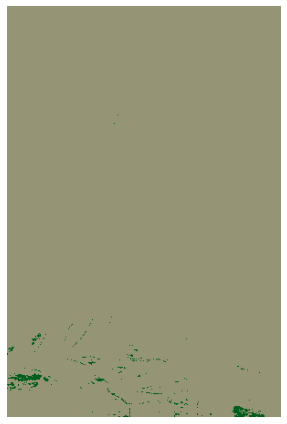

In [171]:
image = read_image("./image.jpg")
result = clusterize_image(image)
show_image(result)
save_image(result, "result.jpg")